In [1]:
import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
print(np.__version__)
import aplpy

1.16.5


In [2]:
##################################################################################################
### setup 
##################################################################################################
## picks for the accurate catalog
rms = 3.0e6
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 17
prune_min_peak = 6
prune_min_mean = 2
path = '/Users/hph/cmzoom_catalog/catalog_acc/'
catalog = Table.read(path+'catalog_acc.fits')
#######################################
### picks for the complete catalog
# rms = 3.0e6
# dend_min_v = 3
# dend_min_d = 1
# dend_min_pix = 17
# prune_min_peak = 4
# prune_min_mean = 2
# path = '/Users/hph/cmzoom_catalog/catalog_complete/'
# catalog = Table.read(path+'catalog_complete.fits')
#################################################

### set condition to exclude sgrA*
ca = (catalog['mask_num']==27)
catalog.remove_rows(ca)
#######################################

date = '_02-02-20'
targetname = '_rms3e6_k14_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date

sma_path = path
herschel_path = path
catalog_path = path
figure_path = path

In [40]:
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
#sns.set_style('white')
cond = (catalog['mask_num']!=13) & (catalog['mask_num']!=17) & (catalog['mask_num']!=19) & (catalog['mask_num']!=33) & (catalog['mask_num']!=35) 
#(catalog['mask_num']!=27) #& (catalog['mass']<1e4)
glon = catalog['glon'][cond]
glat = catalog['glat'][cond]
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
pc_per_pixside = cmz.distance*(0.00013888888888)/(360/(2*np.pi))
glon_bins = np.linspace(map_l_min,map_l_max,25)
glat_bins = np.linspace(map_b_min,map_b_max,8)
hdu=fits.open(path+'CMZoom_continuum_pbcor.fits')
data = hdu[0].data
header = hdu[0].header
w = wcs.WCS(path+'CMZoom_continuum_pbcor.fits').celestial
glon_pix = np.rint(w.wcs_world2pix(np.flip(glon_bins),0,0)[0])
glon_pix = glon_pix.astype(int)
glat_pix = np.rint(w.wcs_world2pix(0,glat_bins,0)[1])
glat_pix = glat_pix.astype(int)

glon_weights = np.zeros(len(glon_pix)-1)
glat_weights = np.zeros(len(glat_pix)-1)

glon_bin_width = glon_bins[1]-glon_bins[0]
glat_bin_width = glat_bins[1]-glat_bins[0]

for i in range(len(glon_pix)-1):
    glon_weights[i]=np.sum(np.isfinite(data[:,glon_pix[i]:glon_pix[i+1]]))
        
for i in range(len(glat_pix)-1):
    glat_weights[i]=np.sum(np.isfinite(data[glat_pix[i]:glat_pix[i+1],:]))

        

print(glon_weights)
print(glat_weights)


[254773. 127964.      0.      0.      0. 194728. 239921. 339697. 177884.
 736268. 553018. 243237. 397662. 111965. 162902. 395652. 422410. 146644.
 130794. 166362. 181856.      0.      0.  43785.]
[  43766.   63336.  447106. 1589658. 1629932. 1143511.  110213.]


In [41]:
leafglon_binned = np.histogram(catalog['glon'][cond],bins=glon_bins,weights=catalog['mass'][cond])[0]
leafglat_binned = np.histogram(catalog['glat'][cond],bins=glat_bins,weights=catalog['mass'][cond])[0]

l_weighted_catalog = np.zeros_like(leafglon_binned,dtype=float)
cond = (np.flip(glon_weights)!=0)
for i in range(len(leafglon_binned)):
    if cond[i]:
        l_weighted_catalog[i]=(leafglon_binned[i]/(np.flip(glon_weights)[i]*pc_per_pixside*pc_per_pixside))

b_weighted_catalog = np.zeros_like(leafglat_binned,dtype=float)
cond = (np.flip(glat_weights)!=0)
for i in range(len(leafglat_binned)):
    if cond[i]:
        b_weighted_catalog[i]=(leafglat_binned[i]/(np.flip(glat_weights)[i]*pc_per_pixside*pc_per_pixside))

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/str

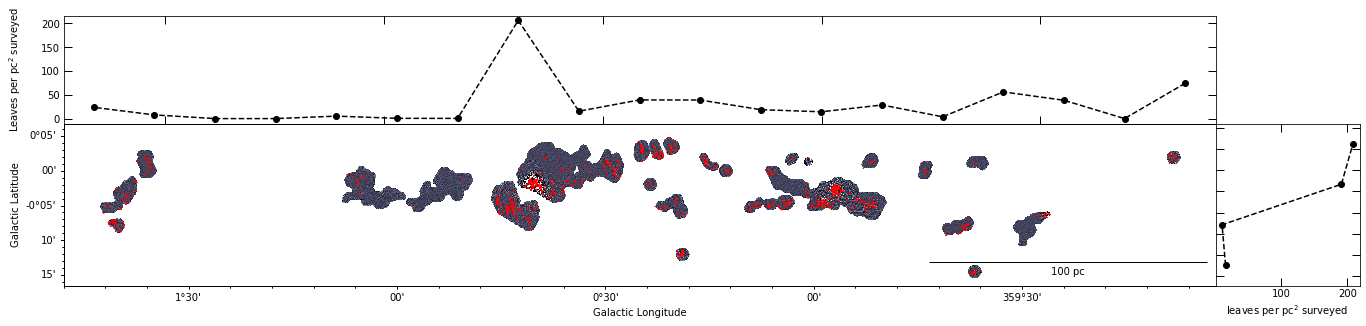

In [94]:
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
%matplotlib inline
#sns.set_style('white')
cond = (catalog['mask_num']!=27)

glon = catalog['glon'][cond]
glat = catalog['glat'][cond]
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
# glon_bins = np.linspace(map_l_min,map_l_max,15)
# glat_bins = np.linspace(map_b_min,map_b_max,10)

xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'
xcolor = 'k'
ycolor = 'k'

left = 0.1
width = 0.8
fig = plt.figure(3,figsize=(20,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
subplot = aplpy.FITSFigure(path+'CMZoom_continuum_pbcor.fits', 
                           figure = fig, subplot=[0.1, 0.01, 0.8, 0.75], convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='bone')
subplot.show_contour(path+'dendrogram_mask_pruned'+targetname+'.fits',
                     colors = 'red', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.set_nan_color('white')
subplot.add_scalebar(length=2400./3600.)
subplot.scalebar.set_label('100 pc')
subplot.scalebar.set_color('k')
ax2=plt.gca()

ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])#, sharey=ax2)
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])#,sharex=ax1)
ax1.set_ylabel('Leaves per pc$^2$ surveyed', labelpad=18)
ax1.plot(glon_bins[:-1]+(glon_bin_width/2),l_weighted_catalog,ls='--',marker='o',color='k')

ax1.set_xlim(map_l_min,map_l_max)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=True)
ax1.axes.xaxis.set_ticklabels([])
ax1.invert_xaxis()

ax3.set_xlabel('leaves per pc$^2$ surveyed')
ax3.plot(b_weighted_catalog,glat_bins[:-1]+(glat_bin_width/2),ls='--',marker='o',color='k')

ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=True,labelleft=False)
ax3.set_ylim(map_b_min,map_b_max)
#plt.savefig(path + 'lb_hist'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [6]:
cond

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
print(glon_bins)

In [ ]:
leaf_weights = np.zeros_like(catalog['glon'])
glon_bin_width = glon_bins[1]-glon_bins[0]
for i in range(len(leaf_weights)):
    for j in range(len(glon_bins)-1):
        if (glon_bins[j+1]>catalog['glon'][i]>glon_bins[j]):
            leaf_weights[i]=glon_weights[j]

In [ ]:
print(glon_weights)


In [ ]:
plt.hist(leaf_weights*pc_per_pixside**2)

In [40]:
pc_per_pixside = cmz.distance*(0.00013888888888)/(360/(2*np.pi))
print(pc_per_pixside**2)


0.0003903057593208481


In [44]:
leaf_weights==0

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [66]:
catalog_binned = np.histogram(catalog['glon'],bins=glon_bins)[0]

In [63]:
glon_weights = np.zeros(len(glon_pix)-1)

for i in range(len(glon_pix)-1):
    glon_weights[i]=np.sum(np.isfinite(data[:,glon_pix[i]:glon_pix[i+1]]))

In [52]:
data[:,0:glon_pix[0]].shape

(2800, 31)

In [55]:
print(glon_bins)

[-0.9        -0.71192857 -0.52385714 -0.33578571 -0.14771429  0.04035714
  0.22842857  0.4165      0.60457143  0.79264286  0.98071429  1.16878571
  1.35685714  1.54492857  1.733     ]


In [58]:
print(glon_pix)

[   31  1385  2739  4093  5447  6802  8156  9510 10864 12218 13572 14926
 16280 17634 18989]


In [65]:
print(np.flip(glon_weights))

[  43785.   60932.  314859.  167345.  693715.  412700.  466696.  576065.
 1046220.  440828.  421640.       0.       0.  382737.]


In [73]:
catalog_binned==0

array([False, False, False, False, False, False, False, False, False,
        True, False,  True,  True, False])

In [76]:
np.flip(glon_weights)==0

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False])

In [91]:
weighted_catalog[cond]=(catalog_binned[cond]/(np.flip(glon_weights)[cond]*pc_per_pixside*pc_per_pixside))

In [92]:
weighted_catalog

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [82]:
np.flip(glon_weights)

array([ 17.08953767,  23.78211053, 122.89128107,  65.31571729,
       270.76095983, 161.07918687, 182.15413665, 224.84148724,
       408.34569152, 172.05770727, 164.56852036,   0.        ,
         0.        , 149.38445541])

In [89]:
catalog_binned[0]/(np.flip(glon_weights)[0]*pc_per_pixside*pc_per_pixside)

0.1755460011618266

In [100]:
weighted_catalog = np.zeros_like(catalog_binned,dtype=float)
cond = (np.flip(glon_weights)!=0)
for i in range(len(catalog_binned)):
    if cond[i]:
        weighted_catalog[i]=(catalog_binned[i]/(np.flip(glon_weights)[i]*pc_per_pixside*pc_per_pixside))

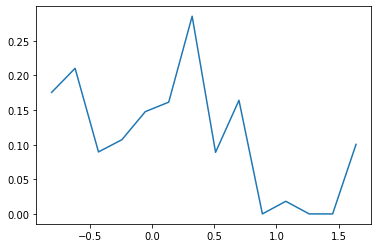

In [109]:
plt.plot(glon_bins[:-1]+(glon_bin_width/2),weighted_catalog)

In [76]:
plt.close()

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: T

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Use

(-0.5, 881.5)


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Use

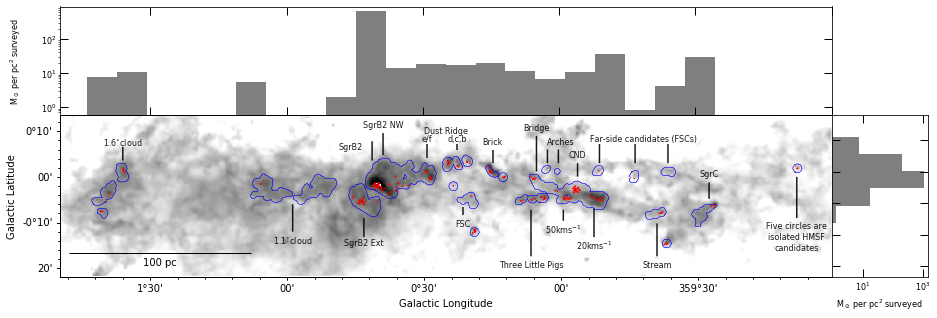

In [42]:
#######################################
### make new backdrop mosaic
#######################################

### load Herschel data
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
%matplotlib inline
#sns.set_style('white')
cond = (catalog['mask_num']!=27)
glon = catalog['glon']
glat = catalog['glat']
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
# glon_bins = np.linspace(map_l_min,map_l_max,15)
# glat_bins = np.linspace(map_b_min,map_b_max,10)

xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'
xcolor = 'k'
ycolor = 'k'

left = 0.1
width = 0.8

fig = plt.figure(3,figsize=(13.4,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
subplot = aplpy.FITSFigure(path+'cmz_column_submap.fits', 
                           figure = fig, subplot=[0.1, 0.01, 0.8, 0.75], convention='calabretta')
vmin,vmax=1e22,1e24
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='log',cmap='gray_r')
subplot.show_contour(path+'dendrogram_mask_pruned'+targetname+'.fits',
                     colors = 'red', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid',alpha=0.8)
subplot.show_contour(path+'mask_new_sgrc.fits',
                     colors = 'blue', levels = [40,41,42,43,44,45,46,47], linewidths = 0.1, alpha=1.0,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.set_nan_color('white')
subplot.add_scalebar(length=2400./3600.,corner='bottom left')
subplot.scalebar.set_label('100 pc')
subplot.scalebar.set_color('k')
ax2=plt.gca()

plt.rcParams.update({'font.size': 8}) #set fontsize
color='black'
alpha=0.9
#subplot.add_label(1.5,0.28, 'CMZoom Coverage', color='black',alpha=0.65, fontsize=14)
cloud16 = np.array([[1.6,1.6],[0.06,0.11]])
cloud11 = np.array([[0.98,0.98],[-0.2,-0.1]])
#missing = np.array([[0.8,0.8],[-0.30,-0.25]])
sgrb2ext = np.array([[0.72,0.72],[-0.27+0.05,-0.20+0.05]])
sgrb2 = np.array([[0.69,0.69],[0.13,0.06]])
sgrb2nw = np.array([[0.65,0.65],[0.16,0.08]])
dref = np.array([[0.49,0.49],[0.12,0.07]])
drdcb = np.array([[0.38,0.38],[0.12, 0.1]])
far0 = np.array([[0.36,0.36],[-0.14,-0.11]])
brick = np.array([[0.25,0.25],[0.1,0.05]])
tlp = np.array([[0.11,0.11],[-0.29, -0.12]])
fifty = np.array([[-0.008,-0.008],[-0.16,-0.12]])
twenty = np.array([[359.88,359.88],[-0.22,-0.115]])
cnd = np.array([[359.94,359.94],[0.05,0.001]])
bridge = np.array([[0.09,0.09],[0.15,0.02]])
arches = np.array([[0.01,0.01],[0.10,0.05]])
arches2 = np.array([[0.05,0.05],[0.10,0.05]])
far1 = np.array([[359.86,359.86],[0.12,0.05]])
far2 = np.array([[359.73,359.73],[0.12,0.05]])
far3 = np.array([[359.61,359.61],[0.12,0.05]])
sgrc = np.array([[359.46,359.46],[-0.02,-0.08]])
stream = np.array([[359.65,359.65],[-0.29,-0.17]])
isolated = np.array([[359.14,359.14],[-0.15,0.0]])
line_list=[cloud16,cloud11,sgrb2ext,sgrb2,sgrb2nw,dref,drdcb,far0,brick,tlp,
           fifty,twenty,cnd,bridge,arches,arches2,far1,far2,far3,sgrc,stream,isolated]
subplot.show_lines(line_list, color='black',alpha=0.9)
subplot.add_label(cloud16[0,0],cloud16[1,0]+0.07, '1.6$^{\circ}$cloud', color=color,alpha=alpha)
subplot.add_label(cloud11[0,0],cloud11[1,0]-0.03, '1.1$^{\circ}$cloud', color=color,alpha=alpha)
#subplot.add_label(missing[0,0],missing[1,0]-0.03, 'Not covered', color=color,alpha=alpha)
subplot.add_label(sgrb2ext[0,0]-0.13+0.13,sgrb2ext[1,0]-0.02, 'SgrB2 Ext', color=color,alpha=alpha)
subplot.add_label(sgrb2[0,0]+0.08,sgrb2[1,0]-0.02, 'SgrB2', color=color,alpha=alpha)
subplot.add_label(sgrb2nw[0,0],sgrb2nw[1,0]+0.03, 'SgrB2 NW', color=color,alpha=alpha)
subplot.add_label(drdcb[0,0]+0.04,drdcb[1,0]+0.05, 'Dust Ridge', color=color,alpha=alpha)
subplot.add_label(dref[0,0],dref[1,0]+0.02, 'e/f', color=color,alpha=alpha)
subplot.add_label(drdcb[0,0],drdcb[1,0]+0.02, 'd,c,b', color=color,alpha=alpha)
subplot.add_label(far0[0,0],far0[1,0]-0.03, 'FSC', color=color,alpha=alpha)
subplot.add_label(brick[0,0],brick[1,0]+0.03, 'Brick', color=color,alpha=alpha)
subplot.add_label(tlp[0,0],tlp[1,0]-0.03, 'Three Little Pigs', color=color,alpha=alpha)
subplot.add_label(fifty[0,0],fifty[1,0]-0.03, '50kms$^{-1}$', color=color,alpha=alpha)
subplot.add_label(twenty[0,0],twenty[1,0]-0.03, '20kms$^{-1}$', color=color,alpha=alpha)
subplot.add_label(cnd[0,0],cnd[1,0]+0.03, 'CND', color=color,alpha=alpha)
subplot.add_label(bridge[0,0],bridge[1,0]+0.03, 'Bridge', color=color,alpha=alpha) #H$_2$CO
subplot.add_label(arches[0,0]-0.01,arches[1,0]+0.03, 'Arches', color=color,alpha=alpha)
subplot.add_label(far2[0,0]-0.03,far2[1,0]+0.02, 'Far-side candidates (FSCs)', color=color,alpha=alpha)
subplot.add_label(sgrc[0,0],sgrc[1,0]+0.03, 'SgrC', color=color,alpha=alpha)
subplot.add_label(stream[0,0],stream[1,0]-0.03, 'Stream', color=color,alpha=alpha)
subplot.add_label(isolated[0,0]+0.19-0.19,isolated[1,0]+0.1-0.13, 'Five circles are', color=color,alpha=alpha)
subplot.add_label(isolated[0,0]+0.18-0.18,isolated[1,0]+0.06-0.13, 'isolated HMSF', color=color,alpha=alpha)
subplot.add_label(isolated[0,0]+0.18-0.18,isolated[1,0]+0.02-0.13, 'candidates', color=color,alpha=alpha)


print(ax2.get_xlim())

ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])#, sharey=ax3)
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])#,sharex=ax1)
ax1.set_ylabel('M$_\odot$ per pc$^2$ surveyed', labelpad=18)
glonscaling=1.#0.95
#ax1.plot((glon_bins[:-1]+(glon_bin_width/2))*glonscaling,l_weighted_catalog,ls='--',marker='o',color='k')
ax1.bar(x=glon_bins[:-1]+(glon_bin_width/2),height=l_weighted_catalog,width=glon_bin_width,color='k',alpha=0.5)

#ax1.set_xlim(map_l_min,map_l_max)
ax1.set_xlim(map_l_min-0.1,map_l_max+0.1)
#ax1.set_ylim(-0.01,0.33)
ax1.set_yscale('log')
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=True)
ax1.axes.xaxis.set_ticklabels([])
ax1.invert_xaxis()

glatscaling=1. #0.7
glatshift =0 # 0.01
ax3.set_xlabel('M$_\odot$ per pc$^2$ surveyed')
#ax3.plot(b_weighted_catalog,(glat_bins[:-1]+(glat_bin_width/2))*glatscaling-glatshift,
#         ls='--',marker='o',color='k')
ax3.barh(y=glat_bins[:-1]+(glat_bin_width/2),width=b_weighted_catalog,height=glat_bin_width,alpha=0.5,color='k')

#ax3.set_xlim(-0.1,2.3)
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=True,labelleft=False)
ax3.set_ylim(map_b_min-0.06,map_b_max+0.07)
ax3.set_xscale('log')
plt.savefig(path + 'lb_weighted'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()


In [61]:
print(map_l_max)

1.733


In [79]:
print(glon_bin_width,glat_bin_width)

0.09079310344827507 0.02742857142857144


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: T

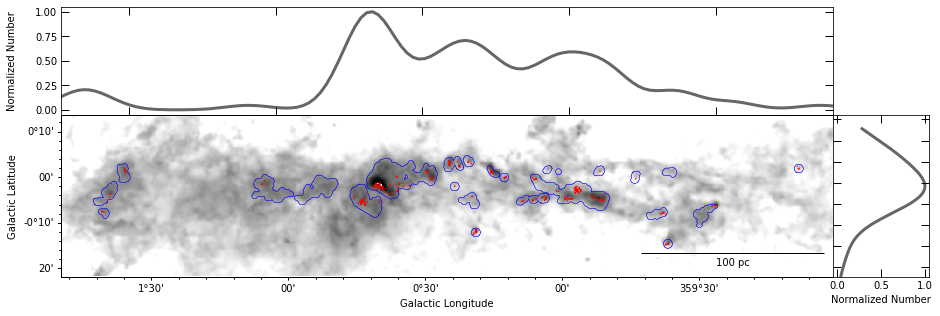

In [21]:
####################################################
### lb histogram with kde 
####################################################
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
%matplotlib inline
#sns.set_style('white')
cond = (catalog['mask_num']!=27)

glon = catalog['glon'][cond]
glat = catalog['glat'][cond]
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
glon_bins = np.linspace(map_l_min,map_l_max,15)
glat_bins = np.linspace(map_b_min,map_b_max,10)

xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'
xcolor = 'k'
ycolor = 'k'

#mosaic_image = fits.getdata(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
left = 0.1
width = 0.8
fig = plt.figure(3,figsize=(13.4,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
subplot = aplpy.FITSFigure(path+'cmz_column_submap.fits', 
                           figure = fig, subplot=[0.1, 0.01, 0.8, 0.75], convention='calabretta')
vmin,vmax=1e22,1e24
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='log',cmap='gray_r')
subplot.show_contour(path+'dendrogram_mask_pruned'+targetname+'.fits',
                     colors = 'red', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid',alpha=0.8)
subplot.show_contour(path+'mask_new_sgrc.fits',
                     colors = 'blue', levels = [40,41,42,43,44,45,46,47], linewidths = 0.1, alpha=1.0,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.set_nan_color('white')
subplot.add_scalebar(length=2400./3600.)
subplot.scalebar.set_label('100 pc')
subplot.scalebar.set_color('k')
ax2=plt.gca()

ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])#, sharey=ax2)
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])#,sharex=ax1)
ax1.set_ylabel('Normalized Number', labelpad=18)
# h1,l1,m1 = ax1.hist(glon,glon_bins,color=xcolor,orientation='vertical', histtype='step', linewidth=3,
#                     alpha=.6,label='Galactic Longitude histogram of leaves')
ax1.plot(glonkde[1],glonkde[2],color=xcolor, linewidth=3,
                    alpha=.6,label='Galactic Longitude histogram of leaves')
ax1.set_xlim(map_l_min,map_l_max)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=True)
ax1.axes.xaxis.set_ticklabels([])
#ax1.set_yscale('log')
ax1.invert_xaxis()

ax3.set_xlabel('Normalized Number')
#ax3.tick_params(width=2, length=10, color = ycolor,labelcolor=ycolor,direction='in')
# h3, l3, m3 = ax3.hist(glat,glat_bins,orientation='horizontal',color=ycolor, histtype='step', linewidth=3,
#          alpha=0.6,label='Galactic Latitude distribution of leaves')
ax3.plot(glatkde[2],glatkde[1],color=xcolor, linewidth=3,
                    alpha=.6,label='Galactic Longitude histogram of leaves')
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=True,labelleft=False)
ax3.set_ylim(map_b_min,map_b_max)
#ax3.set_xscale('log')
plt.savefig(path + 'lb_hist'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()


In [19]:
def get_histkde(data, bins='', nbins=50, norm=True, cum=False):

    """Get Kernel Density Estimation histogram
    See: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    See: https://seaborn.pydata.org/tutorial/distributions.html
    Note: Do not try in log space
    Parameters
    ----------
    data : np.array
        input data
    bins : list
        input bin edges for histogram calculaiton; default=''
    nbins : int
        number of bins to determine if bins is not given; defult=50
    logbins : bool
        logarithmically spaced bins if bins is not given
    norm : bool
        normalise such that max is equal to unity; default=True
    cum : bool
        cumulative distorbution; otherwise probability distorbution
    Returns
    -------
    bins : list
        bin edges for histogram calculaiton
    bin_cent : np.array
        bin centres, for easy plotting in matplotlib
    hist : np.array
        histogram data for each bin centre
    """

    data = data.flatten()
    nsample = len(data)

    if bins=='':
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

        bmin = vmin - (np.absolute(vmin)*1)
        bmax = vmax + (np.absolute(vmax)*0.3)

        bins = np.linspace(bmin, bmax, nbins+1)
    else:
        nbins = len(bins)-1

    bins_cent = np.empty([nbins])

    for i in range(nbins):
        bins_cent[i] = np.nanmean([bins[i], bins[i+1]])

    data_ = data[:, np.newaxis]
    bins_cent_ = bins_cent[:, np.newaxis]

    #Bandwidth Cross-Validation in Scikit-Learn
    #Fuck knows, see: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    if nsample <20:
        grid = GridSearchCV(KernelDensity(), {'bandwidth': bins_cent}, cv=nsample) # 20-fold cross-validation
    else:
        grid = GridSearchCV(KernelDensity(), {'bandwidth': bins_cent}, cv=20) # 20-fold cross-validation
    grid.fit(data_)
    bw = grid.best_params_['bandwidth']

    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data_)

    log_density_values = kde.score_samples(bins_cent_)
    hist = np.exp(log_density_values)

    if cum:
        hist = np.cumsum(hist)
    if norm:
        hist = hist/np.nanmax(hist)

    return(bins, bins_cent, hist)

In [20]:
cond = (catalog['mask_num']!=27)

glonkde = get_histkde(glon[cond], bins='',nbins=200, norm=True, cum=False)
glatkde = get_histkde(glat[cond], bins='',nbins=200, norm=True, cum=False)

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
print(len(glon),len(catalog['mask_num']))

249 249


In [10]:

massglon_binned = np.histogram(catalog['glon'],bins=glon_bins,weights=catalog['mass'])[0]
massglat_binned = np.histogram(catalog['glat'],bins=glat_bins,weights=catalog['mass'])[0]

ml_weighted_catalog = np.zeros_like(massglon_binned,dtype=float)
cond = (np.flip(glon_weights)!=0)
for i in range(len(massglon_binned)):
    if cond[i]:
        ml_weighted_catalog[i]=(massglon_binned[i]/(np.flip(glon_weights)[i]*pc_per_pixside*pc_per_pixside))

mb_weighted_catalog = np.zeros_like(massglat_binned,dtype=float)
cond = (np.flip(glat_weights)!=0)
for i in range(len(massglat_binned)):
    if cond[i]:
        mb_weighted_catalog[i]=(massglat_binned[i]/(np.flip(glat_weights)[i]*pc_per_pixside*pc_per_pixside))

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:287: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: T

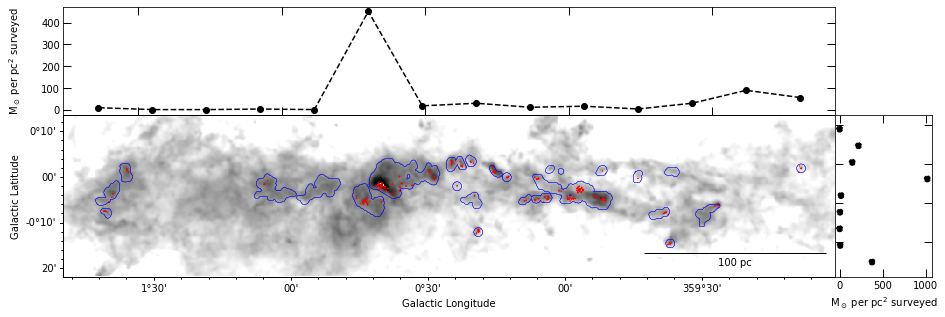

In [22]:
##########################################
### mass weighted histogram 
##########################################
#######################################
### make new backdrop mosaic
#######################################

### load Herschel data
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
%matplotlib inline
#sns.set_style('white')

left = 0.1
width = 0.8

fig = plt.figure(3,figsize=(13.4,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
subplot = aplpy.FITSFigure(path+'cmz_column_submap.fits', 
                           figure = fig, subplot=[0.1, 0.01, 0.8, 0.75], convention='calabretta')
vmin,vmax=1e22,1e24
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='log',cmap='gray_r')
subplot.show_contour(path+'dendrogram_mask_pruned'+targetname+'.fits',
                     colors = 'red', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid',alpha=0.8)
subplot.show_contour(path+'mask_new_sgrc.fits',
                     colors = 'blue', levels = [40,41,42,43,44,45,46,47], linewidths = 0.1, alpha=1.0,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.set_nan_color('white')
subplot.add_scalebar(length=2400./3600.)
subplot.scalebar.set_label('100 pc')
subplot.scalebar.set_color('k')
ax2=plt.gca()

ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])#, sharey=ax2)
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])#,sharex=ax1)
ax1.set_ylabel('M$_\odot$ per pc$^2$ surveyed', labelpad=18)
ax1.plot(glon_bins[:-1]+(glon_bin_width/2),ml_weighted_catalog,ls='--',marker='o',color='k')

#ax1.set_xlim(map_l_min,map_l_max)
#ax1.set_ylim(-0.01,0.33)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=True)
ax1.axes.xaxis.set_ticklabels([])
ax1.invert_xaxis()
#ax1.set_yscale('log')

ax3.set_xlabel('M$_\odot$ per pc$^2$ surveyed')
ax3.scatter(mb_weighted_catalog,glat_bins[:-1]+(glat_bin_width/2),ls='--',marker='o',color='k')
#ax3.set_xlim(-0.1,2.3)
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=True,labelleft=False)
#ax3.set_ylim(map_b_min,map_b_max)
#ax3.set_xscale='log'
#plt.savefig(path + 'lb_weighted'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()
